<a href="https://www.kaggle.com/code/aleksandrmorozov123/credit-risk-models?scriptVersionId=193480606" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
# import the required libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# get the data and summary statistics

df = pd.read_csv ('/kaggle/input/default-of-credit-card-clients-dataset/UCI_Credit_Card.csv')
df.describe().transpose ().round (2)

,count,mean,std,min,25%,50%,75%,max
ID,30000.0,15000.50,8660.40,1.0,7500.75,15000.5,22500.25,30000.0
LIMIT_BAL,30000.0,167484.32,129747.66,10000.0,50000.00,140000.0,240000.00,1000000.0
SEX,30000.0,1.60,0.49,1.0,1.00,2.0,2.00,2.0
EDUCATION,30000.0,1.85,0.79,0.0,1.00,2.0,2.00,6.0
MARRIAGE,30000.0,1.55,0.52,0.0,1.00,2.0,2.00,3.0
AGE,30000.0,35.49,9.22,21.0,28.00,34.0,41.00,79.0
PAY_0,30000.0,-0.02,1.12,-2.0,-1.00,0.0,0.00,8.0
PAY_2,30000.0,-0.13,1.20,-2.0,-1.00,0.0,0.00,8.0
PAY_3,30000.0,-0.17,1.20,-2.0,-1.00,0.0,0.00,8.0
PAY_4,30000.0,-0.22,1.17,-2.0,-1.00,0.0,0.00,8.0


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 0.98, 'Pairplot of selected variables')

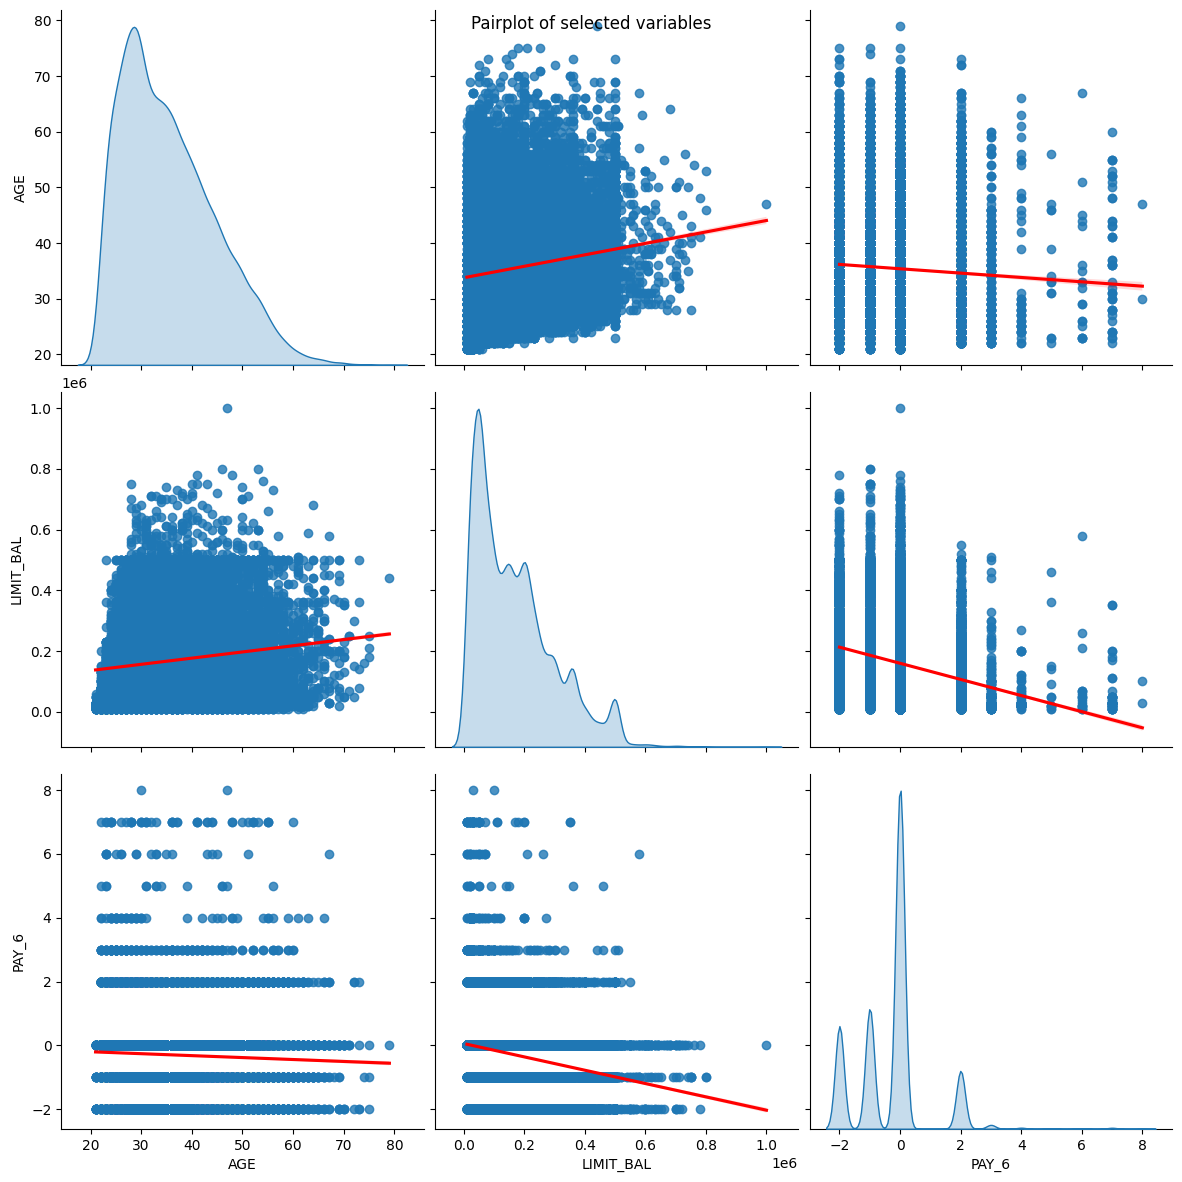

In [3]:
COLS_TO_PLOT = ["AGE", "LIMIT_BAL", "PAY_6"]
pair_plot = sns.pairplot(df[COLS_TO_PLOT], kind="reg", diag_kind="kde", height=4, 
                         plot_kws={"line_kws":{"color":"red"}})
pair_plot.fig.suptitle("Pairplot of selected variables")

In [ ]:
pair_plot = sns.pairplot(data=df, x_vars=COLS_TO_PLOT, 
                         y_vars=COLS_TO_PLOT, hue="SEX",
                         height=4)
pair_plot.fig.suptitle("Pairplot of selected variables")

In [ ]:
ax = sns.jointplot(data=df, x = "AGE", y= "LIMIT_BAL", hue="SEX", height=10)
ax.fig.suptitle("Age vs. limit balance")

**Function for plotting the correaltion heatmap**

In [ ]:
def plot_correlation_matrix(corr_mat):
    sns.set(style="white")
    mask = np.zeros_like(corr_mat, dtype=bool)
    mask[np.triu_indices_from(mask)] = True
    fig, ax = plt.subplots()
    cmap = sns.diverging_palette(240, 10, n=9, as_cmap=True)
    sns.heatmap(corr_mat, mask=mask, cmap=cmap, 
                vmax=.3, center=0, square=True,
                linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)
    ax.set_title("Correlation Matrix", fontsize=16)
    sns.set(style="darkgrid")
    
corr_mat = df.select_dtypes(include="number").corr()
plot_correlation_matrix(corr_mat)

In [ ]:
ax = sns.boxplot(data=df, y="AGE", x="MARRIAGE", hue="SEX")
ax.set_title("Distribution of age")

In [ ]:
ax = sns.violinplot(x="EDUCATION", y="LIMIT_BAL", hue="SEX", split=True, data=df)
ax.set_title("Distribution of limit balance per education level", fontsize=16)

In [ ]:
ax = df.groupby("EDUCATION")["default.payment.next.month"].value_counts(normalize=True).unstack() \
.plot(kind="barh", stacked="True")
ax.set_title("Percentage of default per education level", fontsize=16)
ax.legend(title="Default", bbox_to_anchor=(1,1))

**Training the model**

In [4]:
from sklearn.model_selection import train_test_split

X = df.copy()
y = X.pop("default.payment.next.month")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = 42)

print("Target distribution - train")
print(y_train.value_counts(normalize = True).values)
print("Target distribution - test")
print(y_test.value_counts(normalize = True).values)

Target distribution - train
[0.77879167 0.22120833]
Target distribution - test
[0.77883333 0.22116667]


In [5]:
# define the size of the validation and test sets
VALID_SIZE = 0.1
TEST_SIZE = 0.2

# create the initial split - training and temp
X_train, X_temp, y_train, y_temp = train_test_split(X, y,
                                                    test_size=(VALID_SIZE + TEST_SIZE),
                                                    stratify=y,random_state=42)

# calculate the new test size
new_test_size = np.around(TEST_SIZE / (VALID_SIZE + TEST_SIZE), 2)

# create the valid and test sets
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp,
                                                    test_size=new_test_size,
                                                    stratify=y_temp,
                                                    random_state=42)

print("Percentage of data in each set ----")
print(f"Train: {100 * len(X_train) / len(X):.2f}%")
print(f"Valid: {100 * len(X_valid) / len(X):.2f}%")
print(f"Test: {100 * len(X_test) / len(X):.2f}%")
print("")
print("Class distribution in each set ----")
print(f"Train: {y_train.value_counts(normalize=True).values}")
print(f"Valid: {y_valid.value_counts(normalize=True).values}")
print(f"Test: {y_test.value_counts(normalize=True).values}")

Percentage of data in each set ----
Train: 70.00%
Valid: 9.90%
Test: 20.10%

Class distribution in each set ----
Train: [0.77879899 0.22120101]
Valid: [0.77878788 0.22121212]
Test: [0.77880948 0.22119052]


In [6]:
# dealing with missing values
import missingno as msno
from sklearn.impute import SimpleImputer

X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 24 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         30000 non-null  int64  
 1   LIMIT_BAL  30000 non-null  float64
 2   SEX        30000 non-null  int64  
 3   EDUCATION  30000 non-null  int64  
 4   MARRIAGE   30000 non-null  int64  
 5   AGE        30000 non-null  int64  
 6   PAY_0      30000 non-null  int64  
 7   PAY_2      30000 non-null  int64  
 8   PAY_3      30000 non-null  int64  
 9   PAY_4      30000 non-null  int64  
 10  PAY_5      30000 non-null  int64  
 11  PAY_6      30000 non-null  int64  
 12  BILL_AMT1  30000 non-null  float64
 13  BILL_AMT2  30000 non-null  float64
 14  BILL_AMT3  30000 non-null  float64
 15  BILL_AMT4  30000 non-null  float64
 16  BILL_AMT5  30000 non-null  float64
 17  BILL_AMT6  30000 non-null  float64
 18  PAY_AMT1   30000 non-null  float64
 19  PAY_AMT2   30000 non-null  float64
 20  PAY_AM

<Axes: >

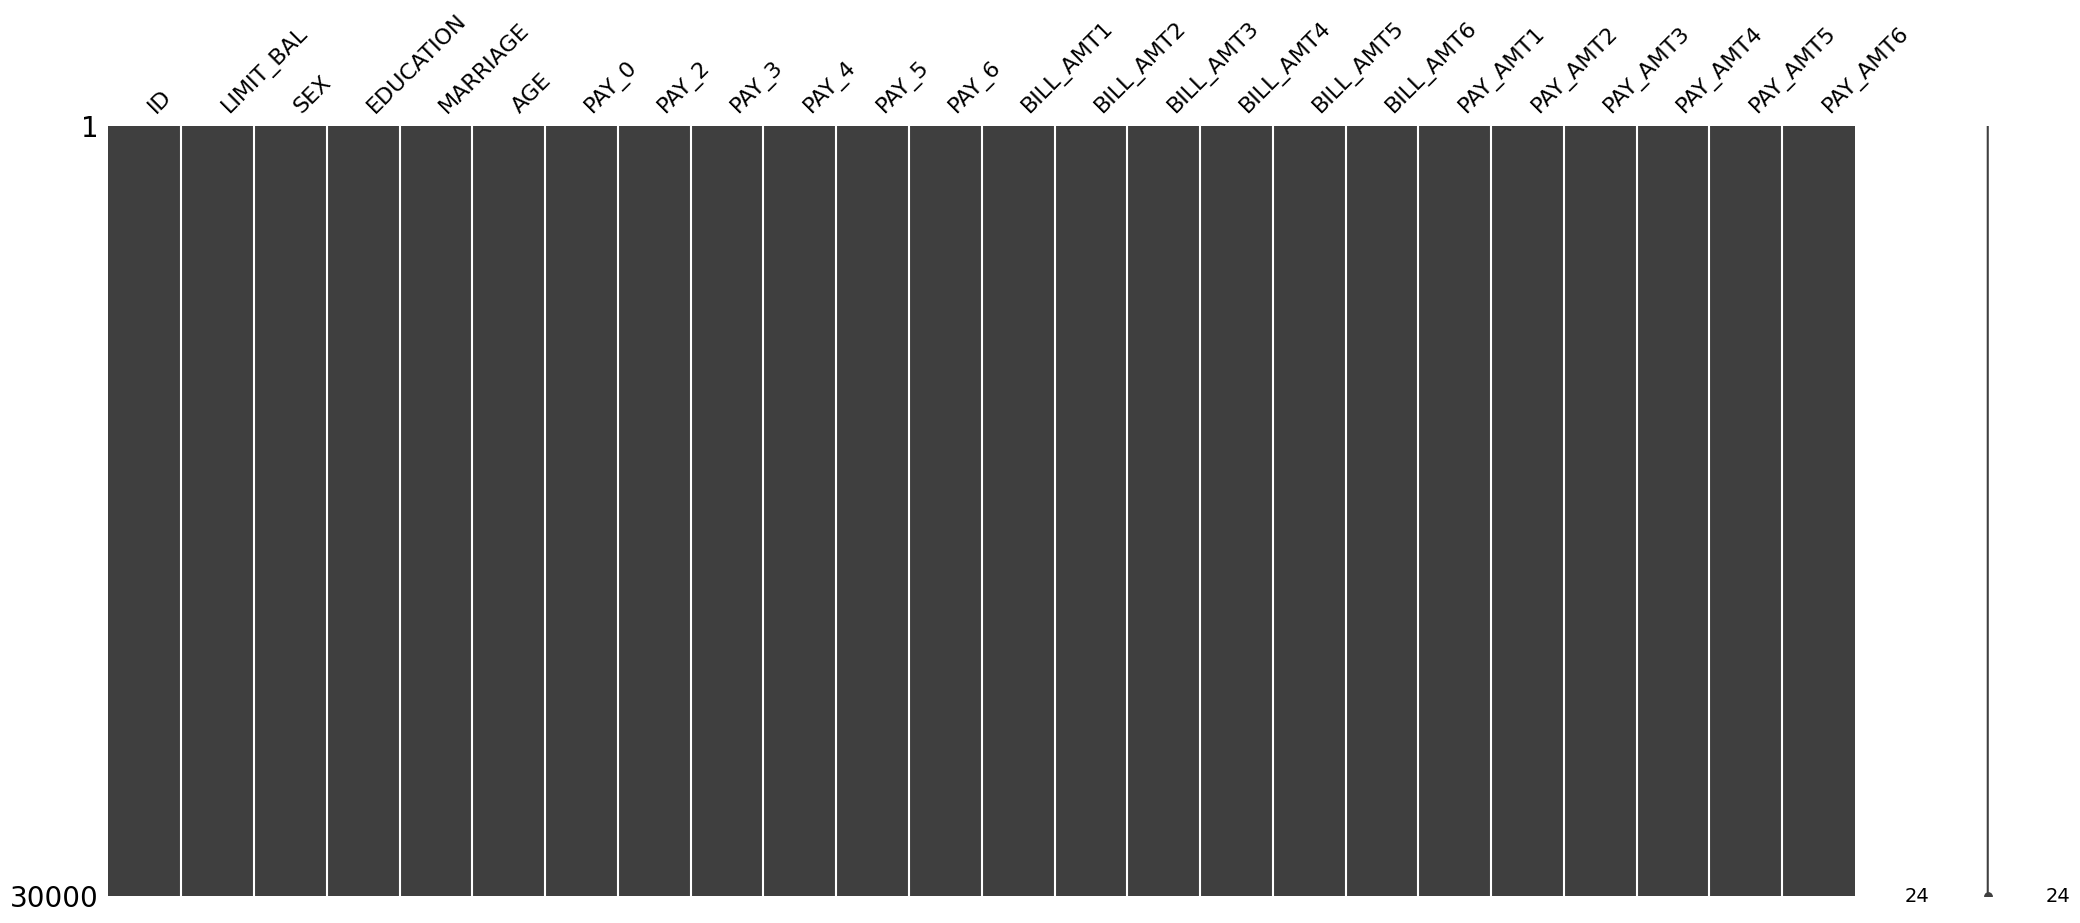

In [7]:
# check the missing values (we don't have this)
msno.matrix(X)

**Decision tree classifier**

[Text(0.5, 0.9, 'x[6] <= 1.5\ngini = 0.345\nsamples = 20999\nvalue = [16354, 4645]'),
 Text(0.25, 0.7, 'x[7] <= 1.5\ngini = 0.276\nsamples = 18804\nvalue = [15691, 3113]'),
 Text(0.125, 0.5, 'x[20] <= 576.5\ngini = 0.243\nsamples = 17208\nvalue = [14768, 2440]'),
 Text(0.0625, 0.3, 'x[12] <= 510.0\ngini = 0.339\nsamples = 4516\nvalue = [3540, 976]'),
 Text(0.03125, 0.1, '\n  (...)  \n'),
 Text(0.09375, 0.1, '\n  (...)  \n'),
 Text(0.1875, 0.3, 'x[10] <= 1.0\ngini = 0.204\nsamples = 12692\nvalue = [11228, 1464]'),
 Text(0.15625, 0.1, '\n  (...)  \n'),
 Text(0.21875, 0.1, '\n  (...)  \n'),
 Text(0.375, 0.5, 'x[11] <= 1.0\ngini = 0.488\nsamples = 1596\nvalue = [923, 673]'),
 Text(0.3125, 0.3, 'x[1] <= 165000.0\ngini = 0.466\nsamples = 1122\nvalue = [707, 415]'),
 Text(0.28125, 0.1, '\n  (...)  \n'),
 Text(0.34375, 0.1, '\n  (...)  \n'),
 Text(0.4375, 0.3, 'x[5] <= 54.5\ngini = 0.496\nsamples = 474\nvalue = [216, 258]'),
 Text(0.40625, 0.1, '\n  (...)  \n'),
 Text(0.46875, 0.1, '\n  (...) 

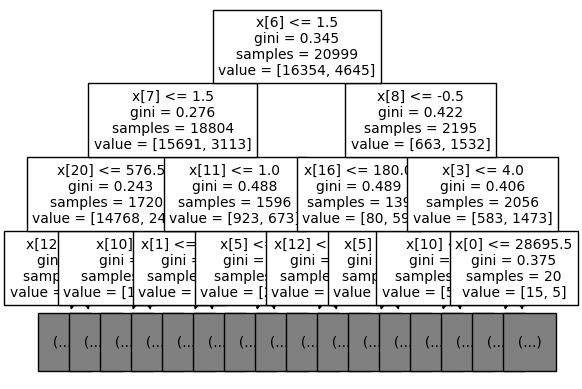

In [8]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn import metrics

tree_classifier = DecisionTreeClassifier(random_state=42)
tree_classifier.fit(X_train, y_train)
y_pred = tree_classifier.predict(X_test)

plot_tree(tree_classifier, max_depth=3, fontsize=10)

[Text(0.5, 0.875, 'PAY_0 <= 1.5\ngini = 0.345\nsamples = 20999\nvalue = [16354, 4645]\nclass = No default'),
 Text(0.25, 0.625, 'PAY_2 <= 1.5\ngini = 0.276\nsamples = 18804\nvalue = [15691, 3113]\nclass = No default'),
 Text(0.125, 0.375, 'PAY_AMT3 <= 576.5\ngini = 0.243\nsamples = 17208\nvalue = [14768, 2440]\nclass = No default'),
 Text(0.0625, 0.125, '\n  (...)  \n'),
 Text(0.1875, 0.125, '\n  (...)  \n'),
 Text(0.375, 0.375, 'PAY_6 <= 1.0\ngini = 0.488\nsamples = 1596\nvalue = [923, 673]\nclass = No default'),
 Text(0.3125, 0.125, '\n  (...)  \n'),
 Text(0.4375, 0.125, '\n  (...)  \n'),
 Text(0.75, 0.625, 'PAY_3 <= -0.5\ngini = 0.422\nsamples = 2195\nvalue = [663, 1532]\nclass = Default'),
 Text(0.625, 0.375, 'BILL_AMT5 <= 180.0\ngini = 0.489\nsamples = 139\nvalue = [80, 59]\nclass = No default'),
 Text(0.5625, 0.125, '\n  (...)  \n'),
 Text(0.6875, 0.125, '\n  (...)  \n'),
 Text(0.875, 0.375, 'EDUCATION <= 4.0\ngini = 0.406\nsamples = 2056\nvalue = [583, 1473]\nclass = Default'),


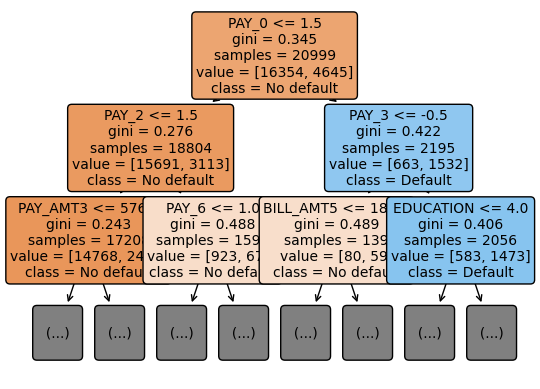

In [9]:
plot_tree(tree_classifier,max_depth=2,
          feature_names=X_train.columns,
          class_names=["No default", "Default"],
          rounded=True, filled=True, fontsize=10
)

In [10]:
# function for performance evaluation report
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def performance_evaluation_report(model, X_test, y_test, show_plot=False, labels=None, show_pr_curve=False):
    """
    Function for creating a performance report of a classification model.
    
    Parameters
    ----------
    model : scikit-learn estimator
        A fitted estimator for classification problems.
    X_test : pd.DataFrame
        DataFrame with features matching y_test
    y_test : array/pd.Series
        Target of a classification problem.
    show_plot : bool
        Flag whether to show the plot
    labels : list
        List with the class names.
    show_pr_curve : bool
        Flag whether to also show the PR-curve. For this to take effect, 
        show_plot must be True.
        
    Return
    ------
    stats : pd.Series
        A series with the most important evaluation metrics
    """

    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:, 1]

    cm = metrics.confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()

    fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_prob)
    roc_auc = metrics.auc(fpr, tpr)

    precision, recall, _ = metrics.precision_recall_curve(
        y_test, y_pred_prob)
    pr_auc = metrics.auc(recall, precision)

    if show_plot:

        if labels is None:
            labels = ["Negative", "Positive"]

        N_SUBPLOTS = 3 if show_pr_curve else 2
        PLOT_WIDTH = 20 if show_pr_curve else 12
        PLOT_HEIGHT = 5 if show_pr_curve else 6

        fig, ax = plt.subplots(
            1, N_SUBPLOTS, figsize=(PLOT_WIDTH, PLOT_HEIGHT))
        fig.suptitle("Performance Evaluation", fontsize=16)

        # plot 1: confusion matrix ----
        
        # preparing more descriptive labels for the confusion matrix
        cm_counts = [f"{val:0.0f}" for val in cm.flatten()]
        cm_percentages = [f"{val:.2%}" for val in cm.flatten()/np.sum(cm)]
        cm_labels = [f"{v1}\n{v2}" for v1, v2 in zip(cm_counts,cm_percentages)]
        cm_labels = np.asarray(cm_labels).reshape(2,2)

        sns.heatmap(cm, annot=cm_labels, fmt="", linewidths=.5, cmap="Greens", 
                    square=True, cbar=False, ax=ax[0],
                    annot_kws={"ha": "center", "va": "center"})
        ax[0].set(xlabel="Predicted label",
                  ylabel="Actual label", title="Confusion Matrix")
        ax[0].xaxis.set_ticklabels(labels)
        ax[0].yaxis.set_ticklabels(labels)

        # plot 2: ROC curve ----
        
        metrics.RocCurveDisplay.from_estimator(model, X_test, y_test, ax=ax[1], name="")
        ax[1].set_title("ROC Curve")
        ax[1].plot(fp/(fp+tn), tp/(tp+fn), "ro",
                   markersize=8, label="Decision Point")
        ax[1].plot([0, 1], [0, 1], "r--")
        
        # alternatively:
        # ax[1].plot(fpr, tpr, "b-", label=f"ROC-AUC = {roc_auc:.2f}")
        # ax[1].set(xlabel="False Positive Rate",
        #           ylabel="True Positive Rate", title="ROC Curve")
        # ax[1].plot(fp/(fp+tn), tp/(tp+fn), "ro",
        #            markersize=8, label="Decision Point")
        # ax[1].plot([0, 1], [0, 1], "r--")
        # ax[1].legend(loc="lower right")
        
        # plot 3: Precision-Recall curve ----

        if show_pr_curve:

            metrics.PrecisionRecallDisplay.from_estimator(model, X_test, y_test, ax=ax[2], name="")
            ax[2].set_title("Precision-Recall Curve")
            
            # alternatively:
            # ax[2].plot(recall, precision, label=f"PR-AUC = {pr_auc:.2f}")
            # ax[2].set(xlabel="Recall", ylabel="Precision",
            #           title="Precision-Recall Curve")
            # ax[2].legend()

    stats = {
        "accuracy": metrics.accuracy_score(y_test, y_pred),
        "precision": metrics.precision_score(y_test, y_pred),
        "recall": metrics.recall_score(y_test, y_pred),
        "specificity": (tn / (tn + fp)),
        "f1_score": metrics.f1_score(y_test, y_pred),
        "cohens_kappa": metrics.cohen_kappa_score(y_test, y_pred),
        "matthews_corr_coeff": metrics.matthews_corrcoef(y_test, y_pred),
        "roc_auc": roc_auc,
        "pr_auc": pr_auc,
        "average_precision": metrics.average_precision_score(y_test, y_pred_prob)
    }

    return stats

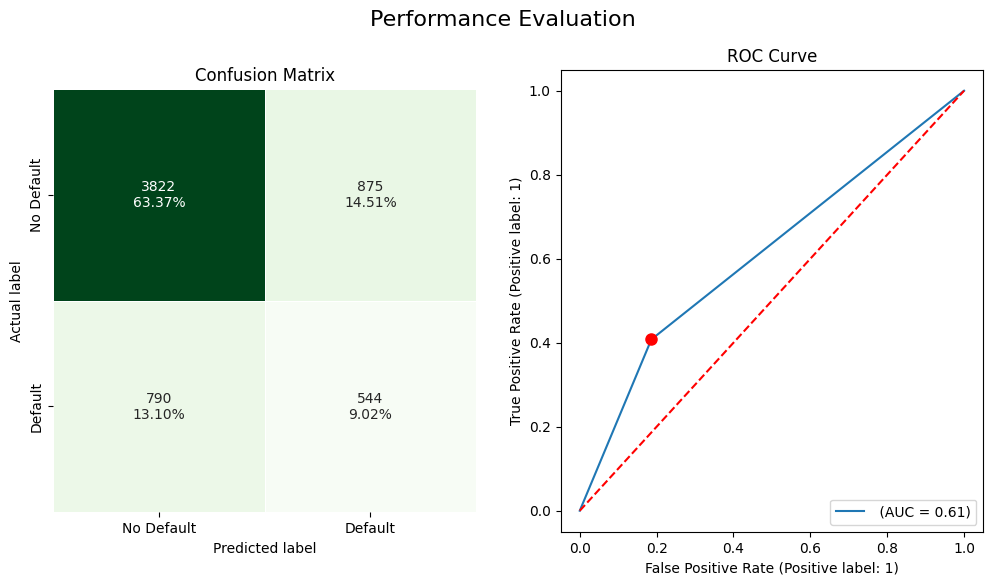

In [11]:
LABELS = ["No Default", "Default"]
tree_perf = performance_evaluation_report(tree_classifier,
                                          X_test,y_test, labels=LABELS,
                                          show_plot=True)

**Evaluation metrics of classification**

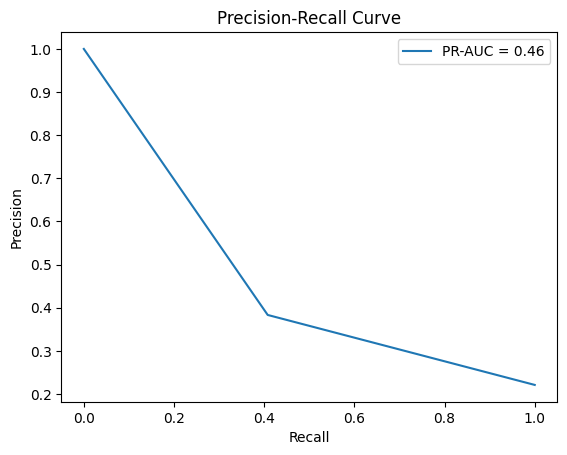

In [12]:
y_pred_prob = tree_classifier.predict_proba(X_test)[:, 1]
precision, recall, _ = metrics.precision_recall_curve(y_test, y_pred_prob)

ax = plt.subplot()
ax.plot(recall, precision,
        label=f"PR-AUC = {metrics.auc(recall, precision):.2f}")
ax.set(title="Precision-Recall Curve", xlabel="Recall", ylabel="Precision")
ax.legend()

Text(0.5, 1.0, 'Precision-Recall Curve')

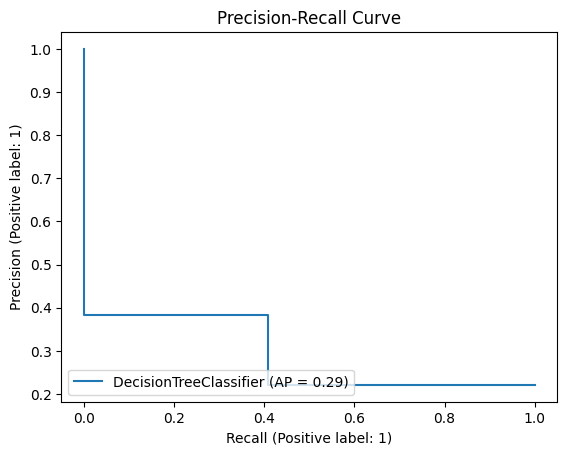

In [13]:
ax = metrics.PrecisionRecallDisplay.from_estimator(tree_classifier, X_test, y_test)
ax.ax_.set_title("Precision-Recall Curve")

**Creating pipeline**

In [14]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline


df = pd.read_csv("/kaggle/input/default-of-credit-card-clients-dataset/UCI_Credit_Card.csv", na_values="")
X = df.copy()
y = X.pop("default.payment.next.month")
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=42
)

num_features = X_train.columns.to_list()
num_pipeline = Pipeline(steps=[("imputer", SimpleImputer(strategy="median"))])

In [15]:
preprocessor = ColumnTransformer(transformers=[("numerical", num_pipeline, num_features)],
                                 remainder="drop")

dec_tree = DecisionTreeClassifier(random_state=42)
tree_pipeline = Pipeline(steps=[("preprocessor", preprocessor),
                                ("classifier", dec_tree)
])

tree_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['ID', 'LIMIT_BAL', 'SEX',
                                                   'EDUCATION', 'MARRIAGE',
                                                   'AGE', 'PAY_0', 'PAY_2',
                                                   'PAY_3', 'PAY_4', 'PAY_5',
                                                   'PAY_6', 'BILL_AMT1',
                                                   'BILL_AMT2', 'BILL_AMT3',
                                                   'BILL_AMT4', 'BILL_AMT5',
                                                   'BILL_AMT6', 'PAY_AMT1',
                                                   'PAY_AMT2', 'PAY_AMT3',
                                                   'PAY_AMT4', 'PAY_AMT5',
                                                   'PAY_AMT6'])])),
                ('classifier', DecisionTreeClassifier(random_state=42))])

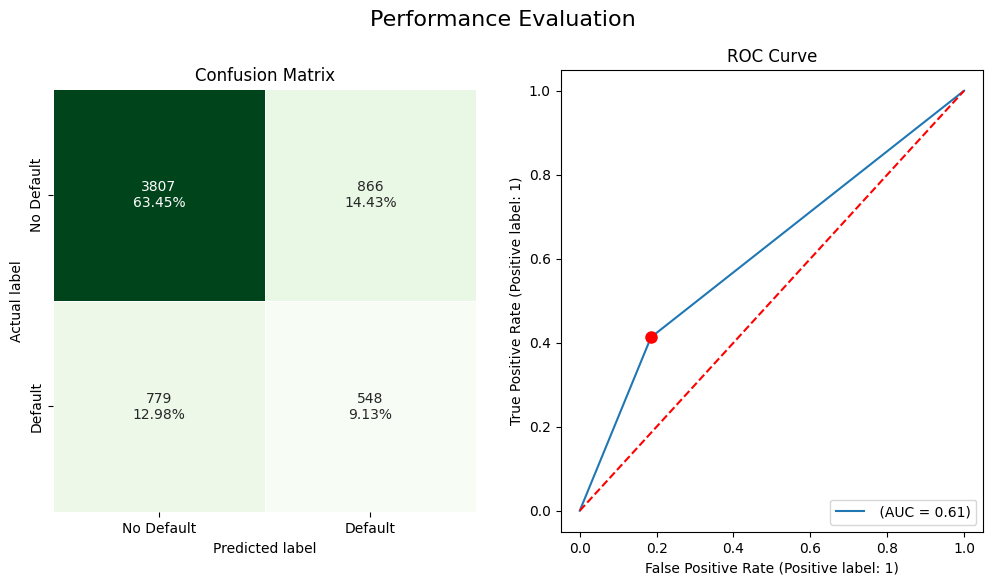

In [16]:
LABELS = ["No Default", "Default"]
tree_perf = performance_evaluation_report(tree_pipeline, X_test,
                                          y_test, labels=LABELS,
                                          show_plot=True)

In [17]:
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np

class OutlierRemover(BaseEstimator, TransformerMixin):
    def __init__(self, n_std=3):
        self.n_std = n_std
    def fit(self, X, y = None):
        if np.isnan(X).any(axis=None):
            raise ValueError("""Missing values in the array! Please remove them.""")
        mean_vec = np.mean(X, axis=0)
        std_vec = np.std(X, axis=0)
        self.upper_band_ = pd.Series(mean_vec + self.n_std * std_vec)
        self.upper_band_ = (
        self.upper_band_.to_frame().transpose())
        self.lower_band_ = pd.Series(
        mean_vec - self.n_std * std_vec)
        self.lower_band_ = (
        self.lower_band_.to_frame().transpose())
        self.n_features_ = len(self.upper_band_.columns)
        return self

    def transform(self, X, y = None):
        X_copy = pd.DataFrame(X.copy())
        upper_band = pd.concat([self.upper_band_] * len(X_copy),
                               ignore_index=True)
        lower_band = pd.concat([self.lower_band_] * len(X_copy),
                               ignore_index=True)
        X_copy[X_copy >= upper_band] = upper_band
        X_copy[X_copy <= lower_band] = lower_band
        return X_copy.values

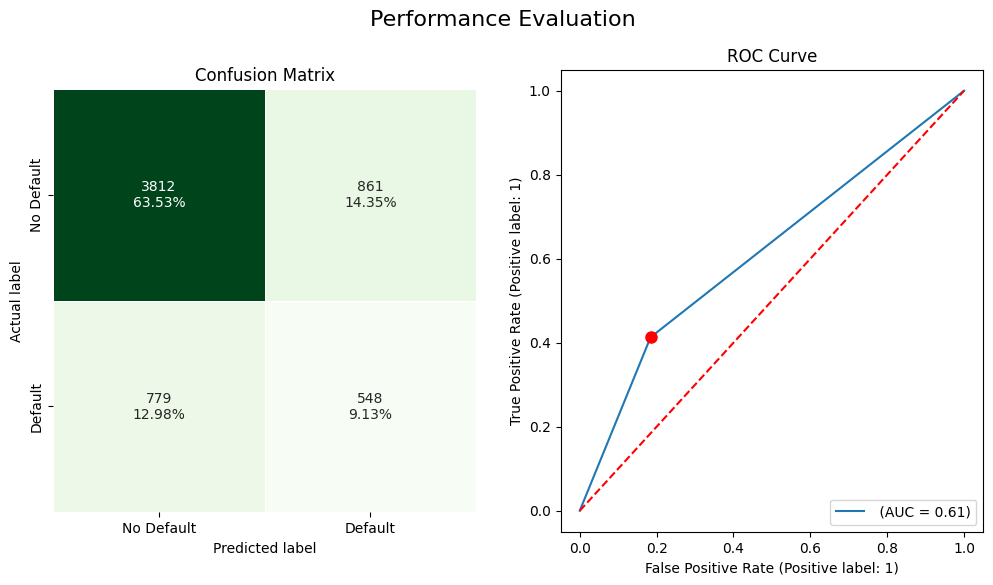

In [18]:
num_pipeline = Pipeline(steps=[("imputer", SimpleImputer(strategy="median")),("outliers", OutlierRemover())])
preprocessor = ColumnTransformer(transformers=[("numerical", num_pipeline, num_features)],remainder="drop")
dec_tree = DecisionTreeClassifier(random_state=42)
tree_pipeline = Pipeline(steps=[("preprocessor", preprocessor), ("classifier", dec_tree)])
tree_pipeline.fit(X_train, y_train)

tree_perf = performance_evaluation_report(tree_pipeline, X_test,
                                          y_test, labels=LABELS,
                                          show_plot=True)

In [19]:
tree_pipeline.named_steps
tree_pipeline.named_steps["classifier"]
(tree_pipeline.named_steps["preprocessor"].named_transformers_["numerical"]["outliers"].upper_band_)

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,40898.138149,555890.511578,3.071463,4.230866,3.11855,63.017818,3.355271,3.462296,3.415506,3.264367,...,252069.405868,235292.85113,222044.17518,216598.486524,54067.496948,66637.658658,57755.3464,49971.471286,49914.412427,58779.830767


In [20]:
from sklearn.model_selection import (GridSearchCV, cross_val_score,
                                     RandomizedSearchCV, cross_validate,
                                     StratifiedKFold)
from sklearn import metrics
k_fold = StratifiedKFold(5, shuffle=True, random_state=42)
cross_val_score(tree_pipeline, X_train, y_train, cv=k_fold)

array([0.72604167, 0.73229167, 0.72520833, 0.728125  , 0.72479167])

In [21]:
cv_scores = cross_validate(tree_pipeline, X_train, y_train, cv=k_fold,
                           scoring=["accuracy", "precision", "recall","roc_auc"])
pd.DataFrame(cv_scores)

,fit_time,score_time,test_accuracy,test_precision,test_recall,test_roc_auc
0,0.940931,0.188970,0.726042,0.386809,0.409048,0.612521
1,1.026363,0.190653,0.732292,0.393708,0.388889,0.609372
2,1.038756,0.190569,0.725208,0.384753,0.403955,0.610217
3,0.976474,0.187344,0.728125,0.390639,0.408663,0.613775
4,1.051311,0.192988,0.724792,0.381735,0.393597,0.606242


In [22]:
param_grid = {
    "classifier__criterion": ["entropy", "gini"],
    "classifier__max_depth": range(3, 11),
    "classifier__min_samples_leaf": range(2, 11),
    "preprocessor__numerical__outliers__n_std": [3, 4]
}

In [23]:
classifier_gs = GridSearchCV(tree_pipeline, param_grid,scoring="recall", 
                             cv=k_fold, n_jobs=-1, verbose=1)
classifier_gs.fit(X_train, y_train)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('numerical',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('outliers',
                                                                                          OutlierRemover())]),
                                                                         ['ID',
                                                                          'LIMIT_BAL',
                                                                          'SEX',
                                                                          'EDUCATION',
                                                                          'MARRIAGE',
                                                                          'AGE',
                                                                          'PAY_0',
                                                                          'PAY_2',
                                                                          'PAY_3',
                                                                          'PAY_4',
                                                                          'PAY_5',
                                                                          'PAY...
                                                                          'BILL_AMT6',
                                                                          'PAY_AMT1',
                                                                          'PAY_AMT2',
                                                                          'PAY_AMT3',
                                                                          'PAY_AMT4',
                                                                          'PAY_AMT5',
                                                                          'PAY_AMT6'])])),
                                       ('classifier',
                                        DecisionTreeClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__criterion': ['entropy', 'gini'],
                         'classifier__max_depth': range(3, 11),
                         'classifier__min_samples_leaf': range(2, 11),
                         'preprocessor__numerical__outliers__n_std': [3, 4]},
             scoring='recall', verbose=1)

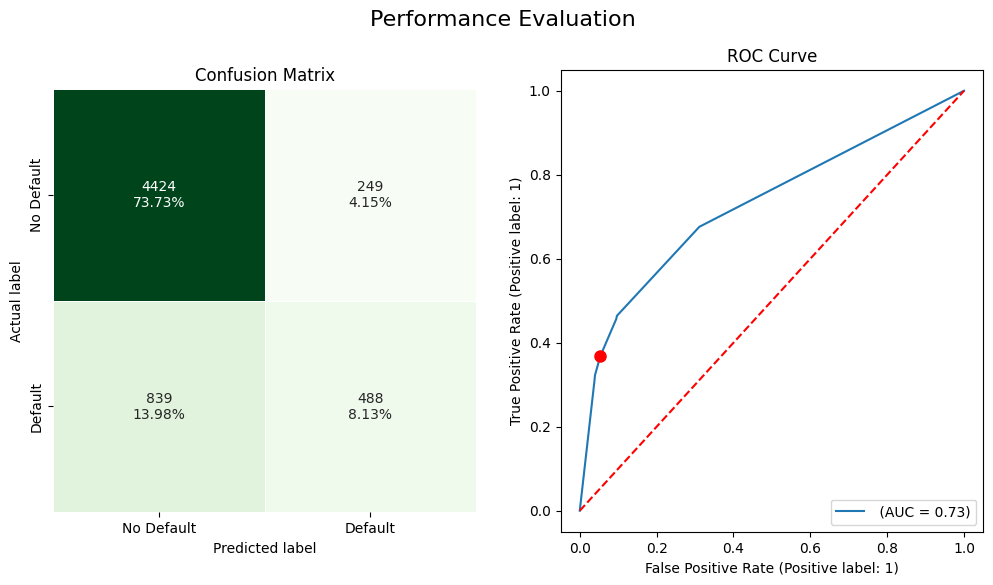

In [25]:
LABELS = ["No Default", "Default"]
tree_gs_perf = performance_evaluation_report(
    classifier_gs, X_test,
    y_test, labels=LABELS,
    show_plot=True
)

In [26]:
classifier_rs = RandomizedSearchCV(tree_pipeline, param_grid, scoring="recall", 
                                   cv=k_fold, n_jobs=-1, verbose=1,
                                   n_iter=100, random_state=42)
classifier_rs.fit(X_train, y_train)
print(f"Best parameters: {classifier_rs.best_params_}")
print(f"Recall (Training set): {classifier_rs.best_score_:.4f}")
print(f"Recall (Test set): {metrics.recall_score(y_test, classifier_rs.predict(X_test)):.4f}")

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters: {'preprocessor__numerical__outliers__n_std': 4, 'classifier__min_samples_leaf': 8, 'classifier__max_depth': 3, 'classifier__criterion': 'gini'}
Recall (Training set): 0.3767
Recall (Test set): 0.3685


In [27]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

classifier_sh = HalvingGridSearchCV(tree_pipeline, param_grid,
                                    scoring="recall", cv=k_fold,
                                    n_jobs=-1, verbose=1,
                                    min_resources="exhaust", factor=3)
classifier_sh.fit(X_train, y_train)

n_iterations: 6
n_required_iterations: 6
n_possible_iterations: 6
min_resources_: 98
max_resources_: 24000
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 288
n_resources: 98
Fitting 5 folds for each of 288 candidates, totalling 1440 fits
----------
iter: 1
n_candidates: 96
n_resources: 294
Fitting 5 folds for each of 96 candidates, totalling 480 fits
----------
iter: 2
n_candidates: 32
n_resources: 882
Fitting 5 folds for each of 32 candidates, totalling 160 fits
----------
iter: 3
n_candidates: 11
n_resources: 2646
Fitting 5 folds for each of 11 candidates, totalling 55 fits
----------
iter: 4
n_candidates: 4
n_resources: 7938
Fitting 5 folds for each of 4 candidates, totalling 20 fits
----------
iter: 5
n_candidates: 2
n_resources: 23814
Fitting 5 folds for each of 2 candidates, totalling 10 fits


HalvingGridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                    estimator=Pipeline(steps=[('preprocessor',
                                               ColumnTransformer(transformers=[('numerical',
                                                                                Pipeline(steps=[('imputer',
                                                                                                 SimpleImputer(strategy='median')),
                                                                                                ('outliers',
                                                                                                 OutlierRemover())]),
                                                                                ['ID',
                                                                                 'LIMIT_BAL',
                                                                                 'SEX',
                                                                                 'EDUCATION',
                                                                                 'MARRIAGE',
                                                                                 'AGE',
                                                                                 'PAY_0',
                                                                                 'PAY_2',
                                                                                 'PAY_3',
                                                                                 'PAY_4',
                                                                                 'PAY_...
                                                                                 'BILL_AMT6',
                                                                                 'PAY_AMT1',
                                                                                 'PAY_AMT2',
                                                                                 'PAY_AMT3',
                                                                                 'PAY_AMT4',
                                                                                 'PAY_AMT5',
                                                                                 'PAY_AMT6'])])),
                                              ('classifier',
                                               DecisionTreeClassifier(random_state=42))]),
                    n_jobs=-1,
                    param_grid={'classifier__criterion': ['entropy', 'gini'],
                                'classifier__max_depth': range(3, 11),
                                'classifier__min_samples_leaf': range(2, 11),
                                'preprocessor__numerical__outliers__n_std': [3,
                                                                             4]},
                    scoring='recall', verbose=1)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

param_grid = [
    {"classifier": [RandomForestClassifier(random_state=42)],
     "classifier__n_estimators": np.linspace(100, 500, 10, dtype=int),
     "classifier__max_depth": range(3, 11),
     "preprocessor__numerical__outliers__n_std": [3, 4]},
    {"classifier": [DecisionTreeClassifier(random_state=42)],
     "classifier__criterion": ["entropy", "gini"],
     "classifier__max_depth": range(3, 11),
     "classifier__min_samples_leaf": range(2, 11),
     "preprocessor__numerical__outliers__n_std": [3, 4]}
]

classifier_gs_2 = GridSearchCV(tree_pipeline, param_grid,
                               scoring="recall", cv=k_fold,
                               n_jobs=-1, verbose=1)
classifier_gs_2.fit(X_train, y_train)

print(f"Best parameters: {classifier_gs_2.best_params_}")
print(f"Recall (Training set): {classifier_gs_2.best_score_:.4f}")
print(f"Recall (Test set): {metrics.recall_score(y_test, classifier_gs_2.predict(X_test)):.4f}")

In [ ]:
pd.DataFrame(classifier_gs_2.cv_results_).sort_values("rank_test_score")

**More advanced methods for training the model**

In [ ]:
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier)
from xgboost.sklearn import XGBClassifier
from lightgbm import LGBMClassifier

rf = RandomForestClassifier(random_state=42)
rf_pipeline = Pipeline(steps=[("preprocessor", preprocessor),
                              ("classifier", rf)])
rf_pipeline.fit(X_train, y_train)

rf_perf = performance_evaluation_report(rf_pipeline, X_test,
                                        y_test, labels=LABELS,
                                        show_plot=True,
                                        show_pr_curve=True)

In [ ]:
gbt = GradientBoostingClassifier(random_state=42)
gbt_pipeline = Pipeline(
steps=[("preprocessor", preprocessor), ("classifier", gbt)])
gbt_pipeline.fit(X_train, y_train)

gbt_perf = performance_evaluation_report(gbt_pipeline, X_test,
                                         y_test, labels=LABELS,
                                         show_plot=True,
                                         show_pr_curve=True)

In [ ]:
xgb = XGBClassifier(random_state=42)
xgb_pipeline = Pipeline(
steps=[("preprocessor", preprocessor), ("classifier", xgb)])
xgb_pipeline.fit(X_train, y_train)

xgb_perf = performance_evaluation_report(xgb_pipeline, X_test,
                                         y_test, labels=LABELS,
                                         show_plot=True,
                                         show_pr_curve=True)

In [ ]:
lgbm = LGBMClassifier(random_state=42)
lgbm_pipeline = Pipeline(steps=[("preprocessor", preprocessor),("classifier", lgbm)])
lgbm_pipeline.fit(X_train, y_train)

lgbm_pipeline.fit(X_train, y_train)
lgbm_perf = performance_evaluation_report(lgbm_pipeline, X_test,
                                          y_test, labels=LABELS,
                                          show_plot=True,
                                          show_pr_curve=True)